In [1]:
import numpy as np
import pickle
from sklearn import metrics
import re
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

import os
import pandas as pd

from ast import literal_eval

from process_predictions import get_predictions
from utils import assess_performance, flatten, compare_preds

import random

import warnings
warnings.filterwarnings('ignore')

In [2]:
all_cols = [
    'subpillars_1d',
    'subpillars_2d'
    ]

In [3]:
DATA_PATH = os.path.join(
    '..', '..', '..', '..', "data", "frameworks_data", 'data_v0.7.1'
)


test_df = pd.read_csv(os.path.join(DATA_PATH, 'new_columns_test_v0.7.1.csv'))


for col in all_cols:

    test_df[col] = test_df[col].apply(
        lambda x: [item for item in literal_eval(x) if item!='NOT_MAPPED']
    )       
    
geo_df = pd.read_csv(os.path.join(DATA_PATH, 'test_v0.7.1_geo_pred.csv'))
geo_df['geo_location_pred'] = geo_df['geo_location_pred'].apply(literal_eval)

## postprocess raw predictions and get results

In [4]:
pillars_1d_tags = ['Covid-19',
 'Casualties',
 'Context',
 'Displacement',
 'Humanitarian Access',
 'Shock/Event',
 'Information And Communication']

pillars_2d_tags = ['At Risk',
 'Priority Interventions',
 'Capacities & Response',
 'Humanitarian Conditions',
 'Impact',
 'Priority Needs']


In [8]:
def get_predictions_all(ratio_proba_threshold, 
    output_columns,
    pillars_2d,
    pillars_1d,
    nb_entries: int, 
    ratio_nb: int):
    
    predictions = {column:[] for column in output_columns }
    for entry_nb in range (nb_entries):
        
        returns_subpillars = ratio_proba_threshold['subpillars'][entry_nb] 
        
        subpillars_2d_tags = {
           key: value for key, value in returns_subpillars.items() if\
                key.split('->')[0] in pillars_2d
        }
        subpillars_1d_tags = {
           key: value for key, value in returns_subpillars.items() if\
                key.split('->')[0] in pillars_1d
        }

        preds_2d = get_preds_entry (subpillars_2d_tags, False, ratio_nb)
        predictions['subpillars_2d'].append(preds_2d)
        
        preds_1d = get_preds_entry (subpillars_1d_tags, False, ratio_nb)
        predictions['subpillars_1d'].append(preds_1d)
        
    return predictions
        


def get_preds_entry (preds_column, return_at_least_one=True, ratio_nb=1, return_only_one=False):
    preds_entry = [
        sub_tag for sub_tag in list(preds_column.keys()) if preds_column[sub_tag]>ratio_nb
    ]
    if return_only_one:
        preds_entry = [
            sub_tag for sub_tag in list(preds_column.keys())\
                if preds_column[sub_tag]==max(list(preds_column.values()))
        ]
    if return_at_least_one:
        if len(preds_entry)==0:
            preds_entry = [
                sub_tag for sub_tag in list(preds_column.keys())\
                    if preds_column[sub_tag]==max(list(preds_column.values()))
            ]
    return preds_entry

In [9]:
pickle_file = open("logs/logged_values_subpillars_data_augmentation.pickle", "rb") ##NAME OF PICKLE FILE
doc = pickle.load(pickle_file)

In [10]:
n_preds = len(doc['preds']['subpillars'])

final_preds = get_predictions_all(
    doc['preds'], 
    ['subpillars_2d', 'subpillars_1d'],
    pillars_2d=pillars_2d_tags,
    pillars_1d=pillars_1d_tags,
    nb_entries=n_preds, 
    ratio_nb=1)


In [11]:
predictions_df = test_df[[
    'excerpt', 'entry_id', 'lang', 'analysis_framework_id'
]]
#predictions_df['sectors'] = final_preds['sectors']
predictions_df['subpillars_2d'] = final_preds['subpillars_2d']
predictions_df['subpillars_1d'] = final_preds['subpillars_1d']
"""predictions_df['gender'] = final_preds['gender']
predictions_df['age'] = final_preds['age']
predictions_df['specific_needs_groups'] = final_preds['specific_needs_groups']
predictions_df['affected_groups'] = final_preds['affected_groups']
predictions_df['severity'] = final_preds['severity']"""

"predictions_df['gender'] = final_preds['gender']\npredictions_df['age'] = final_preds['age']\npredictions_df['specific_needs_groups'] = final_preds['specific_needs_groups']\npredictions_df['affected_groups'] = final_preds['affected_groups']\npredictions_df['severity'] = final_preds['severity']"

In [12]:
predictions_df.head(2)

,excerpt,entry_id,lang,analysis_framework_id,subpillars_2d,subpillars_1d
0,"During the reporting week, IOM provided medica...",16851,en,137.0,[Capacities & Response->International Response],[]
1,Primary and secondary net enrollment rates are...,489433,en,1306.0,[Humanitarian Conditions->Living Standards],[]


In [11]:
predictions_df.to_csv('logs/total_predictions_deployment.csv', index=None)

In [13]:
cols = ['subpillars_2d', 'subpillars_1d']
raw_results = {}
tot_wrong_ids = {}
for col in cols:
    if col=='sectors':
        ids_not_cross = test_df.sectors.apply(lambda x: 'Cross' not in x)
        gt_sectors = test_df[ids_not_cross].sectors.tolist()
        preds_sectors = predictions_df[ids_not_cross].sectors.tolist()
        preds = compare_preds(gt_sectors, preds_sectors)
    else:    
        preds = compare_preds(test_df[col].values, final_preds[col])
        
    results_col = preds['scores']
    raw_results[col] = results_col
    
df_results_raw = pd.DataFrame.from_dict(raw_results, orient='columns')
df_results_raw['names'] = df_results_raw.index
df_results_raw 
#df_results_raw.iloc[[0, 3,4]]

,subpillars_2d,subpillars_1d,names
proportion_perfect_matches,0.48,0.70,proportion_perfect_matches
proportion_at_least_one_false,0.52,0.30,proportion_at_least_one_false
proportion_at_leaset_one_missing,0.34,0.18,proportion_at_leaset_one_missing


In [15]:
#df_results_raw.to_csv('raw_results.csv', index=None)

In [15]:
results_subpillars_2d_original = assess_performance (
    final_preds['subpillars_2d'], 
    test_df['subpillars_2d'].tolist(), 
    sorted(list(set(flatten(test_df['subpillars_2d'])))),
    'subpillars_2d'
    )
results_subpillars_2d_original['names'] = results_subpillars_2d_original.index
results_subpillars_2d_original

,macro_precision,macro_recall,macro_f1_score,1_precision,0_precision,1_recall,0_recall,1_f1_score,0_f1_score,hamming_loss,names
At Risk->Number Of People At Risk,0.509000,0.526000,0.513000,0.019000,0.999000,0.056000,0.997000,0.028000,0.998000,0.004000,At Risk->Number Of People At Risk
At Risk->Risk And Vulnerabilities,0.709000,0.705000,0.707000,0.457000,0.962000,0.447000,0.963000,0.452000,0.963000,0.070000,At Risk->Risk And Vulnerabilities
Capacities & Response->International Response,0.842000,0.812000,0.826000,0.723000,0.962000,0.652000,0.972000,0.686000,0.967000,0.060000,Capacities & Response->International Response
Capacities & Response->Local Response,0.642000,0.599000,0.617000,0.286000,0.998000,0.200000,0.999000,0.235000,0.998000,0.003000,Capacities & Response->Local Response
Capacities & Response->National Response,0.701000,0.703000,0.702000,0.427000,0.975000,0.431000,0.975000,0.429000,0.975000,0.048000,Capacities & Response->National Response
Capacities & Response->Number Of People Reached/Response Gaps,0.775000,0.815000,0.793000,0.561000,0.988000,0.646000,0.984000,0.601000,0.986000,0.027000,Capacities & Response->Number Of People Reache...
Humanitarian Conditions->Coping Mechanisms,0.793000,0.735000,0.761000,0.604000,0.982000,0.482000,0.989000,0.536000,0.985000,0.029000,Humanitarian Conditions->Coping Mechanisms
Humanitarian Conditions->Living Standards,0.771000,0.756000,0.763000,0.632000,0.910000,0.587000,0.925000,0.609000,0.917000,0.136000,Humanitarian Conditions->Living Standards
Humanitarian Conditions->Number Of People In Need,0.718000,0.745000,0.731000,0.440000,0.995000,0.497000,0.994000,0.467000,0.995000,0.011000,Humanitarian Conditions->Number Of People In Need
Humanitarian Conditions->Physical And Mental Well Being,0.817000,0.781000,0.798000,0.682000,0.952000,0.596000,0.966000,0.637000,0.959000,0.073000,Humanitarian Conditions->Physical And Mental W...


In [21]:
#results_subpillars_2d_original.to_csv('subpillars_2d_results.csv', index=None)

In [17]:
import matplotlib.patches as mpatches

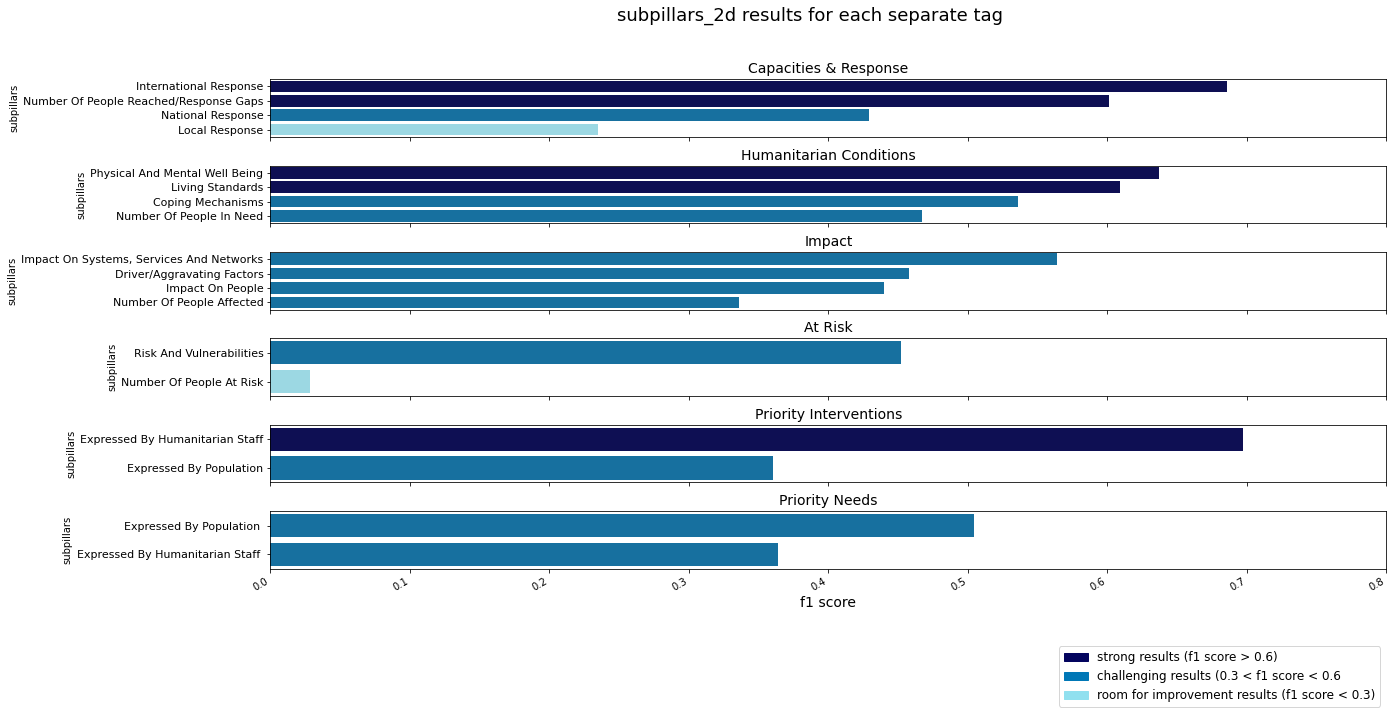

In [18]:
results_subpillars_2d = results_subpillars_2d_original.copy()
results_subpillars_2d.drop(results_subpillars_2d.tail(1).index,inplace=True)
results_subpillars_2d.sort_values(by='1_f1_score', inplace=True, ascending=False)

results_subpillars_2d = results_subpillars_2d[['macro_f1_score', '1_f1_score']].rename(columns={'1_f1_score': 'tag reliability'})
results_subpillars_2d['tag reliability'] = results_subpillars_2d['tag reliability']
results_subpillars_2d['tag_name'] = results_subpillars_2d.index
results_subpillars_2d['pillars'] = results_subpillars_2d['tag_name'].apply(lambda x: x.split('->')[0])
results_subpillars_2d['subpillars'] = results_subpillars_2d['tag_name'].apply(lambda x: x.split('->')[1])
#results_subpillars_2d.sort_values(by='pillars', inplace=True, ascending=True)

results_subpillars_2d.loc['Priority Needs->Expressed By Population', 'subpillars'] = 'Expressed By Population '
results_subpillars_2d.loc['Priority Needs->Expressed By Humanitarian Staff', 'subpillars'] = 'Expressed By Humanitarian Staff '

fig, axes = plt.subplots(6, 1, sharex=True, figsize=(20,10), facecolor='white')


def colors_from_values(values, palette_name):
    # normalize the values to range [0, 1]
    normalized = values 
    # convert to indices
    indices = np.round(normalized * (len(values) - 1)).astype(np.int32)
    # use the indices to get the colors
    palette = sns.color_palette(palette_name, len(values))
    return np.array(palette).take(indices, axis=0)

custom_palette = {}
for v in list(results_subpillars_2d['subpillars']):
    q = results_subpillars_2d[results_subpillars_2d['subpillars']==v]['tag reliability'].values[0]
    #print(q)
    """if q < 0.3:
        custom_palette[v] = '#caf0f8'"""
    if q < 0.3:
        custom_palette[v] = '#90e0ef'
    elif q < 0.6:
        custom_palette[v] = '#0077b6'
    else:
        custom_palette[v] = '#03045e'

ordered_pillars = {
    'At Risk': 3,
 'Priority Interventions': 4,
 'Capacities & Response': 0,
 'Humanitarian Conditions': 1,
 'Impact': 2,
 'Priority Needs': 5
}

for j in range (6):
    pillar_2d_tmp = pillars_2d_tags[j]
    i = ordered_pillars[pillar_2d_tmp]
    subpilars_tmp = results_subpillars_2d[results_subpillars_2d.tag_name.apply(
        lambda x: x.split('->')[0] == pillar_2d_tmp
    )]
    
    y = subpilars_tmp['tag reliability']
    axes[i].set_title(f'{pillar_2d_tmp}', fontsize=14)
    plt.gcf().autofmt_xdate()
    #axes[i].xaxis.set_visible(False)
    axes[i].set_xlim([0, 0.8])
    axes[i].yaxis.set_tick_params(labelsize=11)
    #axes[i].axvline(x=0.5)
    sns.barplot(ax=axes[i], y=subpilars_tmp['subpillars'], x=y, palette=custom_palette).set(xlabel=None)#colors_from_values(y, "rocket_r"))
    plt.subplots_adjust(hspace = 0.5)
    plt.xlabel('f1 score', fontsize=14)

usually_reliable_tags = mpatches.Patch(color='#03045e', label='strong results (f1 score > 0.6)')
fairly_reliable_tags = mpatches.Patch(color='#0077b6', label='challenging results (0.3 < f1 score < 0.6')
not_usually_reliable_tags = mpatches.Patch(color='#90e0ef', label='room for improvement results (f1 score < 0.3)')

handles = [usually_reliable_tags, fairly_reliable_tags, not_usually_reliable_tags]
fig.suptitle('subpillars_2d results for each separate tag', fontsize=18)

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, handles=handles, fontsize=12, loc=4, bbox_to_anchor=(0.9, 0))


#plt.savefig('results_vizu/subpillars2d_with_scores.png', bbox_inches="tight")


## 1d

In [19]:
results_subpillars_1d_original = assess_performance (
    final_preds['subpillars_1d'], 
    test_df['subpillars_1d'].tolist(), 
    sorted(list(set(flatten(test_df['subpillars_1d'])))),
    'subpillars_1d'
    )
results_subpillars_1d_original['names'] = results_subpillars_1d_original.index
results_subpillars_1d_original

,macro_precision,macro_recall,macro_f1_score,1_precision,0_precision,1_recall,0_recall,1_f1_score,0_f1_score,hamming_loss,names
Casualties->Dead,0.804000,0.84200,0.822000,0.615000,0.993000,0.693000,0.990000,0.651000,0.992,0.016000,Casualties->Dead
Casualties->Injured,0.734000,0.79400,0.761000,0.470000,0.998000,0.591000,0.997000,0.523000,0.998,0.004000,Casualties->Injured
Casualties->Missing,0.719000,0.68900,0.703000,0.440000,0.999000,0.379000,0.999000,0.407000,0.999,0.002000,Casualties->Missing
Context->Demography,0.740000,0.69100,0.713000,0.492000,0.989000,0.390000,0.992000,0.435000,0.990,0.019000,Context->Demography
Context->Economy,0.801000,0.78700,0.794000,0.617000,0.985000,0.588000,0.986000,0.602000,0.986,0.028000,Context->Economy
Context->Environment,0.666000,0.72400,0.690000,0.335000,0.996000,0.455000,0.994000,0.386000,0.995,0.010000,Context->Environment
Context->Legal & Policy,0.739000,0.69000,0.712000,0.488000,0.990000,0.387000,0.994000,0.432000,0.992,0.016000,Context->Legal & Policy
Context->Politics,0.734000,0.75400,0.744000,0.475000,0.994000,0.516000,0.993000,0.495000,0.993,0.014000,Context->Politics
Context->Security & Stability,0.813000,0.74800,0.776000,0.651000,0.976000,0.509000,0.986000,0.571000,0.981,0.037000,Context->Security & Stability
Context->Socio Cultural,0.649000,0.63700,0.643000,0.306000,0.992000,0.281000,0.993000,0.293000,0.993,0.015000,Context->Socio Cultural


In [20]:
#results_subpillars_1d_original.to_csv('subpillars_1d_results.csv', index=None)

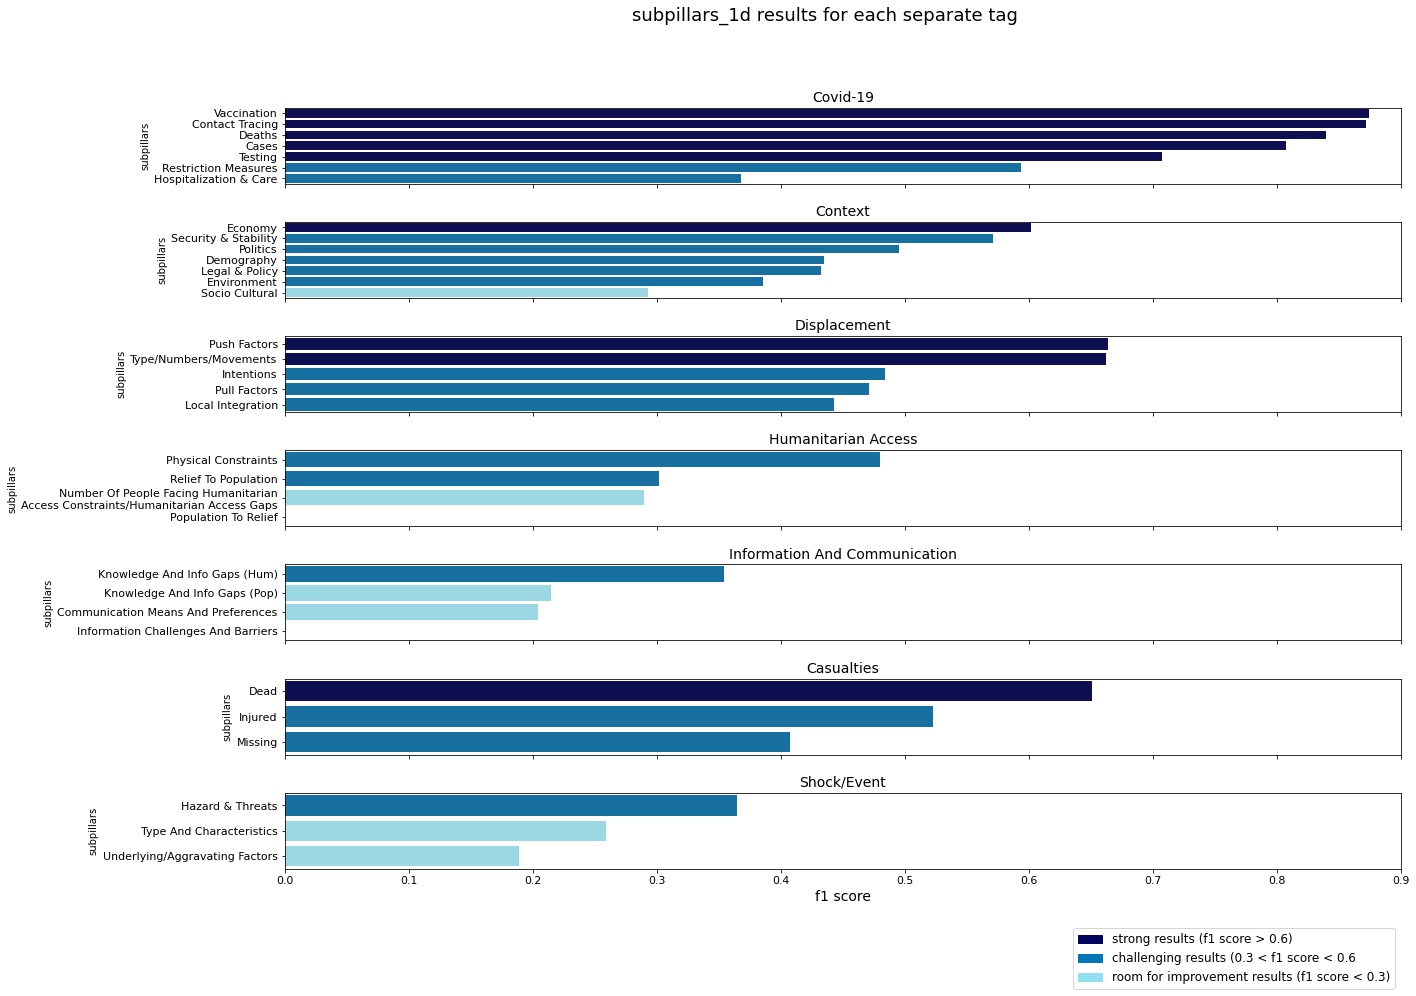

In [20]:
results_subpillars_1d = results_subpillars_1d_original.copy()
results_subpillars_1d.drop(results_subpillars_1d.tail(1).index,inplace=True)
results_subpillars_1d.sort_values(by='1_f1_score', ascending=False, inplace=True)

results_subpillars_1d = results_subpillars_1d[['macro_f1_score', '1_f1_score']].rename(columns={'1_f1_score': 'f1 score'})
results_subpillars_1d['tag_name'] = results_subpillars_1d.index
results_subpillars_1d['pillars'] = results_subpillars_1d['tag_name'].apply(lambda x: x.split('->')[0])
results_subpillars_1d['subpillars'] = results_subpillars_1d['tag_name'].apply(lambda x: x.split('->')[1])

results_subpillars_1d.loc['Humanitarian Access->Number Of People Facing Humanitarian Access Constraints/Humanitarian Access Gaps', 'subpillars'] =\
     'Number Of People Facing Humanitarian\nAccess Constraints/Humanitarian Access Gaps'

fig, axes = plt.subplots(len(pillars_1d_tags), 1, sharex=True, figsize=(20,14), facecolor='white')
custom_palette = {}
for v in list(results_subpillars_1d['subpillars']):
    q = results_subpillars_1d[results_subpillars_1d['subpillars']==v]['f1 score'].values[0]

    if q < 0.3:
        custom_palette[v] = '#90e0ef'
    elif q < 0.6:
        custom_palette[v] = '#0077b6'
    else:
        custom_palette[v] = '#03045e'

ordered_pillars = {
 'Covid-19': 0,
 'Casualties': 5,
 'Context': 1,
 'Displacement': 2,
 'Humanitarian Access': 3,
 'Shock/Event': 6,
 'Information And Communication': 4
}

for j in range (7):
    pillar_1d_tmp = pillars_1d_tags[j]
    i = ordered_pillars[pillar_1d_tmp]
    subpilars_tmp = results_subpillars_1d[results_subpillars_1d.tag_name.apply(
        lambda x: x.split('->')[0] == pillar_1d_tmp
    )]
    
    y = subpilars_tmp['f1 score']
    axes[i].set_title(f'{pillar_1d_tmp}', fontsize=14)
    #plt.gcf().autofmt_xdate()
    #axes[i].xaxis.set_visible(False)
    axes[i].xaxis.set_tick_params(labelsize=11)
    #axes[i].xaxis.set_title(labelsize='large')
    axes[i].set_xlim([0, 0.9])
    axes[i].yaxis.set_tick_params(labelsize=11)
    #axes[i].axvline(x=0.5)
    sns.barplot(ax=axes[i], y=subpilars_tmp['subpillars'], x=y, palette=custom_palette).set(xlabel=None)#colors_from_values(y, "rocket_r"))
    plt.subplots_adjust(hspace = 0.5)
    plt.xlabel('f1 score', fontsize=14)

usually_reliable_tags = mpatches.Patch(color='#03045e', label='strong results (f1 score > 0.6)')
fairly_reliable_tags = mpatches.Patch(color='#0077b6', label='challenging results (0.3 < f1 score < 0.6')
not_usually_reliable_tags = mpatches.Patch(color='#90e0ef', label='room for improvement results (f1 score < 0.3)')

fig.suptitle('subpillars_1d results for each separate tag', fontsize=18)

#unreliable_tags = mpatches.Patch(color='#caf0f8', label='unreliable tags')
handles = [usually_reliable_tags, fairly_reliable_tags, not_usually_reliable_tags]

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, handles=handles, fontsize=12, loc=4, bbox_to_anchor=(0.9, 0))

#plt.savefig('results_vizu/subpillars1d_with_scores.png', bbox_inches="tight")



In [22]:
ids_not_cross = test_df.sectors.apply(lambda x: 'Cross' not in x)
gt_sectors = test_df[ids_not_cross].sectors.tolist()
preds_sectors = predictions_df[ids_not_cross].sectors.tolist()
#results_col = compare_preds(gt_sectors, preds_sectors)

results_sectors_original = assess_performance (
    preds_sectors, 
    gt_sectors, 
    sorted(list(set(flatten(gt_sectors)))),
    'sectors'
    )

results_sectors_original['names'] = results_sectors_original.index
results_sectors_original

,macro_precision,macro_recall,macro_f1_score,1_precision,0_precision,1_recall,0_recall,1_f1_score,0_f1_score,hamming_loss,names
Agriculture,0.7890,0.8300,0.8080,0.5860,0.9930,0.6700,0.9900,0.6250,0.9920,0.0160,Agriculture
Education,0.8960,0.9270,0.9100,0.8010,0.9900,0.8690,0.9840,0.8340,0.9870,0.0240,Education
Food Security,0.9100,0.9010,0.9050,0.8400,0.9800,0.8200,0.9820,0.8300,0.9810,0.0340,Food Security
Health,0.8530,0.8840,0.8670,0.7510,0.9550,0.8500,0.9180,0.7970,0.9360,0.0980,Health
Livelihoods,0.8360,0.8230,0.8290,0.7110,0.9620,0.6790,0.9670,0.6940,0.9640,0.0640,Livelihoods
Logistics,0.8240,0.7890,0.8060,0.6580,0.9910,0.5840,0.9930,0.6190,0.9920,0.0150,Logistics
Nutrition,0.8670,0.9290,0.8960,0.7390,0.9950,0.8700,0.9890,0.7990,0.9920,0.0150,Nutrition
Protection,0.8310,0.8560,0.8430,0.7110,0.9510,0.7820,0.9300,0.7450,0.9400,0.0970,Protection
Shelter,0.8460,0.8670,0.8560,0.7060,0.9860,0.7510,0.9820,0.7280,0.9840,0.0300,Shelter
WASH,0.9220,0.9210,0.9210,0.8550,0.9880,0.8540,0.9880,0.8550,0.9880,0.0230,WASH


In [25]:
results_sectors_original.to_csv('results_sectors.csv', index = None)

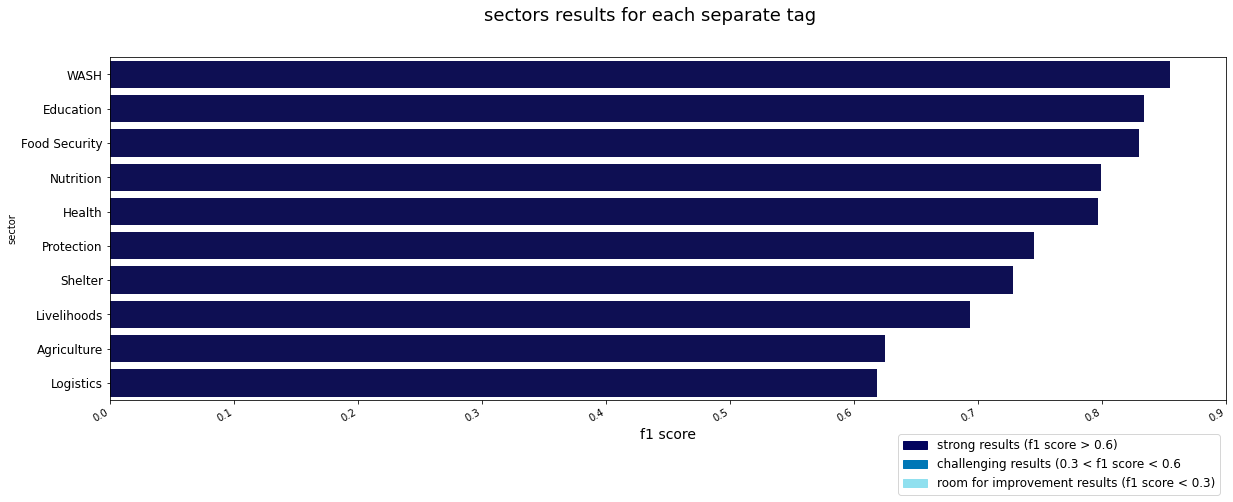

In [32]:
results_sectors = results_sectors_original.copy()
results_sectors.drop(results_sectors.tail(1).index,inplace=True)
results_sectors.sort_values(by='1_f1_score', ascending=False, inplace=True)
results_sectors = results_sectors[['macro_f1_score', '1_f1_score']].rename(columns={'1_f1_score': 'tag reliability'})
results_sectors['tag reliability'] = results_sectors['tag reliability']
results_sectors['sector'] = results_sectors.index

custom_palette = {}
for v in list(results_sectors['sector']):
    q = results_sectors[results_sectors['sector']==v]['tag reliability'].values[0]
    
    if q < 0.3:
        custom_palette[v] = '#90e0ef'
    elif q < 0.6:
        custom_palette[v] = '#0077b6'
    else:
        custom_palette[v] = '#03045e'
    
fig = plt.figure(figsize=(20,7), facecolor='white')
ax = fig.add_subplot()

y = results_sectors['tag reliability']
plt.gcf().autofmt_xdate()
#ax.xaxis.set_visible(False)
ax.set_xlim([0, 0.9])
ax.yaxis.set_tick_params(labelsize=12)
sns.barplot(ax=ax, y=results_sectors['sector'], x=y, palette=custom_palette).set(xlabel=None)#colors_from_values(y, "rocket_r"))
plt.xlabel('f1 score', fontsize=14)

usually_reliable_tags = mpatches.Patch(color='#03045e', label='strong results (f1 score > 0.6)')
fairly_reliable_tags = mpatches.Patch(color='#0077b6', label='challenging results (0.3 < f1 score < 0.6')
not_usually_reliable_tags = mpatches.Patch(color='#90e0ef', label='room for improvement results (f1 score < 0.3)')

fig.suptitle('sectors results for each separate tag', fontsize=18)
#unreliable_tags = mpatches.Patch(color='#caf0f8', label='unreliable tags')
handles = [usually_reliable_tags, fairly_reliable_tags, not_usually_reliable_tags]

fig.legend(handles=handles, fontsize=12, loc=4, bbox_to_anchor=(0.9, 0))


plt.savefig('results_vizu/sectors_with_scores.png', bbox_inches="tight")



## Create testing df for taggers (not needed for predictions and deployment)

In [16]:
geo_df = geo_df.rename(columns={'geo_location_pred': 'geo_location'})
predictions_df = predictions_df.merge(
    right=geo_df,
    on='entry_id'
)

In [17]:
geo_df.columns

Index(['entry_id', 'geo_location'], dtype='object')

In [18]:
def get_clean_output(x):
    return '\n'.join([str({
        '{:s}'.format('\u0332'.join(key)): value}
    ) for key, value in x.items()])

def clean_excerpt(x):
    n = 12
    split_text = x.split(' ')
    final_list = []
    for i in range(0, len(split_text), n): 
        final_list.append(' '.join(split_text[i:i + n]))
    return '\n'.join(final_list)

In [24]:
predictions_df['test_primary_tags'] = test_df.apply(
    lambda x: x.sectors + x.subpillars_1d + x.subpillars_2d + [x.analysis_framework_id], axis=1
)

en_df = predictions_df[predictions_df.lang == 'en']
en_df["test_primary_tags"] = en_df["test_primary_tags"].apply(str)
ids = en_df.groupby("test_primary_tags")["entry_id"].agg(list).values
unique_ids = [list(np.unique(list_)) for list_ in ids]

tot_ids = sorted(unique_ids, key=len)
ids = [
    random.sample(id_tmp, int(len(id_tmp) * 0.02)) for id_tmp in tot_ids
]
taggers_ids = flatten(ids)

tested_cols = [
    'sectors', 'subpillars_2d', 'subpillars_1d', 'age', 'gender', 'severity', 'geo_location' 
]
kept_cols = ['entry_id', 'excerpt'] + tested_cols
taggers_df = predictions_df[predictions_df.entry_id.isin(taggers_ids)][kept_cols]
taggers_df['excerpt'] = taggers_df['excerpt'].apply(clean_excerpt)
taggers_df['predictions'] = taggers_df.apply(
    lambda x: get_clean_output({col:x[col] for col in tested_cols}), axis=1
)
taggers_df['wrong_tags'] = taggers_df.apply(
    lambda x: get_clean_output({col:[] for col in tested_cols}), axis=1
)
taggers_df['missing_tags'] = taggers_df.apply(
    lambda x: get_clean_output({col:[] for col in tested_cols}), axis=1
)
taggers_df.sectors.apply(lambda x: len(x)>0).sum()

taggers_df['specific_needs_groups'] = '[]'
taggers_df['affected_groups'] = '[]'

taggers_df[[
    'entry_id', 
    'excerpt', 
    'predictions', 
    'wrong_tags', 
    'missing_tags',
    'specific_needs_groups',
    'affected_groups'
]].to_csv(
    'models_testing_round3.csv', index=None
)


In [25]:
taggers_df.sectors.apply(lambda x: len(x)>0).sum() / taggers_df.shape[0]

0.6065573770491803

In [21]:
pd.read_csv('models_testing_round3.csv')

,entry_id,excerpt,predictions,wrong_tags,missing_tags,specific_needs_groups,affected_groups
0,489933,"[31st Aug 2021, Adamawa State] (Cholera) The t...",{'s̲e̲c̲t̲o̲r̲s': ['Health']}\n{'s̲u̲b̲p̲i̲l̲l...,{'s̲e̲c̲t̲o̲r̲s': []}\n{'s̲u̲b̲p̲i̲l̲l̲a̲r̲s̲_...,{'s̲e̲c̲t̲o̲r̲s': []}\n{'s̲u̲b̲p̲i̲l̲l̲a̲r̲s̲_...,[],[]
1,183653,"[7th October 2020, Overall Syria] The Ministry...",{'s̲e̲c̲t̲o̲r̲s': ['Health']}\n{'s̲u̲b̲p̲i̲l̲l...,{'s̲e̲c̲t̲o̲r̲s': []}\n{'s̲u̲b̲p̲i̲l̲l̲a̲r̲s̲_...,{'s̲e̲c̲t̲o̲r̲s': []}\n{'s̲u̲b̲p̲i̲l̲l̲a̲r̲s̲_...,[],[]
2,271808,"[February 25, As Sweida] The Director of Healt...",{'s̲e̲c̲t̲o̲r̲s': ['Protection']}\n{'s̲u̲b̲p̲i...,{'s̲e̲c̲t̲o̲r̲s': []}\n{'s̲u̲b̲p̲i̲l̲l̲a̲r̲s̲_...,{'s̲e̲c̲t̲o̲r̲s': []}\n{'s̲u̲b̲p̲i̲l̲l̲a̲r̲s̲_...,[],[]
3,174921,In several UNHCR-managed displacement sites in...,{'s̲e̲c̲t̲o̲r̲s': ['Health']}\n{'s̲u̲b̲p̲i̲l̲l...,{'s̲e̲c̲t̲o̲r̲s': []}\n{'s̲u̲b̲p̲i̲l̲l̲a̲r̲s̲_...,{'s̲e̲c̲t̲o̲r̲s': []}\n{'s̲u̲b̲p̲i̲l̲l̲a̲r̲s̲_...,[],[]
4,174554,"[ 1st July 2020, Borno states] Depicts the nom...",{'s̲e̲c̲t̲o̲r̲s': ['Food Security']}\n{'s̲u̲b̲...,{'s̲e̲c̲t̲o̲r̲s': []}\n{'s̲u̲b̲p̲i̲l̲l̲a̲r̲s̲_...,{'s̲e̲c̲t̲o̲r̲s': []}\n{'s̲u̲b̲p̲i̲l̲l̲a̲r̲s̲_...,[],[]
...,...,...,...,...,...,...,...
98,303849,"Other evidence, including hate statements tagg...",{'s̲e̲c̲t̲o̲r̲s': ['Protection']}\n{'s̲u̲b̲p̲i...,{'s̲e̲c̲t̲o̲r̲s': []}\n{'s̲u̲b̲p̲i̲l̲l̲a̲r̲s̲_...,{'s̲e̲c̲t̲o̲r̲s': []}\n{'s̲u̲b̲p̲i̲l̲l̲a̲r̲s̲_...,[],[]
99,272168,(S)GBV is a plight in Afghanistan. In the bigg...,{'s̲e̲c̲t̲o̲r̲s': ['Protection']}\n{'s̲u̲b̲p̲i...,{'s̲e̲c̲t̲o̲r̲s': []}\n{'s̲u̲b̲p̲i̲l̲l̲a̲r̲s̲_...,{'s̲e̲c̲t̲o̲r̲s': []}\n{'s̲u̲b̲p̲i̲l̲l̲a̲r̲s̲_...,[],[]
100,319997,"Fighting was reported mainly in Kandahar, Helm...",{'s̲e̲c̲t̲o̲r̲s': ['Protection']}\n{'s̲u̲b̲p̲i...,{'s̲e̲c̲t̲o̲r̲s': []}\n{'s̲u̲b̲p̲i̲l̲l̲a̲r̲s̲_...,{'s̲e̲c̲t̲o̲r̲s': []}\n{'s̲u̲b̲p̲i̲l̲l̲a̲r̲s̲_...,[],[]
101,338477,- Project and programme implementors need to e...,{'s̲e̲c̲t̲o̲r̲s': ['Livelihoods']}\n{'s̲u̲b̲p̲...,{'s̲e̲c̲t̲o̲r̲s': []}\n{'s̲u̲b̲p̲i̲l̲l̲a̲r̲s̲_...,{'s̲e̲c̲t̲o̲r̲s': []}\n{'s̲u̲b̲p̲i̲l̲l̲a̲r̲s̲_...,[],[]
